In [1]:
# Importar las librerías necesarias

import numpy as np
import qibo
import matplotlib.pyplot as plt
from qibo import callbacks, gates, hamiltonians, models
from qibo.symbols import X, Y, Z, I
from sklearn.datasets import make_moons
from qibo.models import Circuit

# Se desactiva los mensajes de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

# Fijar el backend en el que se ejecutará el programa
qibo.set_backend("tensorflow")

[Qibo 0.1.12.dev0|INFO|2024-05-22 12:50:19]: Using tensorflow backend on /device:CPU:0


In [2]:
# Definir variables necesarias para la ejecución del algoritmo:

nclasses=2
measured_qubits= int(np.ceil(np.log2(nclasses)))
nqubits=2
nlayers=3
nshots=10000

In [3]:
def procesdata(data): 
    data=np.array(data)
    Min=data.min(axis=0)
    Max=data.max(axis=0)
    data=(2*data-Max-Min)/(Max-Min)
    one=np.ones((len(data),2))
    data_p=np.c_[data,data]
    return data_p

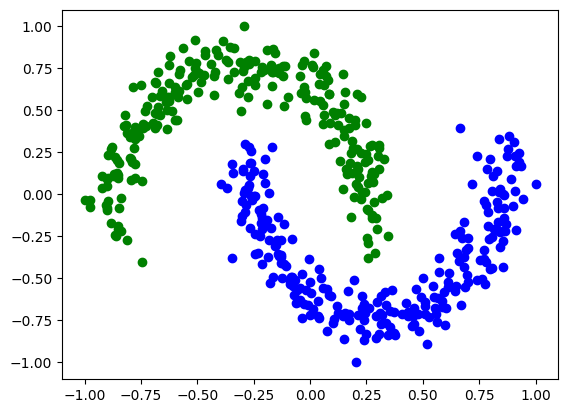

In [4]:
num_inputs = 2
num_samples = 500
X,y=make_moons(num_samples,noise=0.1)

y01 = 1 * (np.sum(X, axis=1) >= 0) # in { 0,  1}
y_one_hot = np.zeros((num_samples, 2))

for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1
X_pad=procesdata(X)

for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

plt.show()

In [5]:
Y = 2*y -np.ones(len(y))

num_data = len(Y)
num_train = int(0.80 * num_data)

index = np.random.permutation(range(num_data))

Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]
X_train = X_pad[index[:num_train]]
X_val = X_pad[index[num_train:]]

In [6]:
def create_circuit(w,x, nqubits= 2):
    
    c= Circuit(nqubits=nqubits)
    
    # ENCODING:

    c.add(gates.RY(q=0, theta = w[0]*x[0]+w[4]))
    c.add(gates.RY(q=1, theta = w[1]*x[1]+w[5]))
    
    c.add(gates.RZ(q=0, theta = w[2]*x[2]+w[6]))
    c.add(gates.RZ(q=1, theta = w[3]*x[3]+w[7]))
    
    # CIRCUITO VARIACIONAL:
    
    # LAYER 1
    c.add(gates.RY(q=0, theta = w[4]))
    c.add(gates.RY(q=1, theta = w[5]))
     
    c.add(gates.CZ(0,1))
    
    c.add(gates.RY(q=0, theta = w[6]))
    c.add(gates.RY(q=1, theta = w[7]))
    
    # LAYER 2
    c.add(gates.RY(q=0, theta = w[8]))
    c.add(gates.RY(q=1, theta = w[9]))
    
    c.add(gates.CZ(0,1))
    
    c.add(gates.RY(q=0, theta = w[10]))
    c.add(gates.RY(q=1, theta = w[11]))
    
    # LAYER 3
    c.add(gates.RY(q=0, theta = w[12]))
    c.add(gates.RY(q=1, theta = w[13]))

    c.add(gates.CZ(0,1))
    
    c.add(gates.RY(q=0, theta = w[14]))
    c.add(gates.RY(q=1, theta = w[15]))
    
    # ÚLTIMA ROTACIÓN EN Y:
    c.add(gates.RY(q=0, theta = w[16]))
    c.add(gates.RY(q=1, theta = w[17]))
    
    # MEDIMOS EL QUBIT 0:
    c.add(gates.M(0))
    
    return c

In [7]:
def sqloss_acc(labels, predictions):
    sqloss = 0
    acc = 0
    # Recorremos todas las instancias comparando el label conocido con la predicción que ha realizado el modelo.
    for label, prediction in zip(labels, predictions):
        
        # Modificamos el valor de loss
        sqloss = sqloss + (label - prediction)**2
        
        #Vemos si el label y la predicción coincide para calcular el accuracy
        if np.sign(label)==np.sign(prediction):
            acc += 1
    # dividir entre la cantidad de datos de entrada para obtener un valor entre 0 y 1.
    sqloss = sqloss / len(labels)
    acc = acc / len(labels)
    
    print('Loss: ', sqloss.numpy(), 'Acc: ', acc)
    return sqloss, acc

In [8]:
#  En esta función se llama a la función de crear el circuito con los parámetros necesarios.
def Classifier_circuit(theta,data,nqubits=2):
    circ = create_circuit(theta,data, nqubits)
    return circ

In [9]:
# Definir el observable:
def hamiltonian():
    Obj = np.prod([ Z(0), I(1)])
    h = hamiltonians.SymbolicHamiltonian(Obj)
    return h

In [10]:
def Predictions(data, theta, nqubits, nshots=10000):

    c = Classifier_circuit(theta,data,nqubits)
    h = hamiltonian()
    expected_value = h.expectation(c.execute().state())
    
    return expected_value

In [11]:
def Cost_function(theta, data, Y, nqubits, nshots=10000):
    predictions = [Predictions(x, theta,nqubits) for x in data]
    return sqloss_acc(Y, predictions)[0]

In [12]:
params_SGD = [-0.94029041,  1.76279408,  0.07174585, -0.08851703,  0.59543365,
       -0.61919009,  0.16678696, -0.11759714,  0.40629924, -0.21482006,
        0.15629836, -0.10974645,  0.16246831, -0.12307243,  0.23741627,
        0.00333674,  0.24791843, -0.00205158]

In [13]:
# Calcular coste con todos los datos
cost_val = Cost_function(params_SGD, X_val, Y_val,nqubits)
cost_all = Cost_function(params_SGD, X_pad, Y,nqubits)

Loss:  0.43241086306503357 Acc:  0.85


Loss:  0.3534984650110077 Acc:  0.896


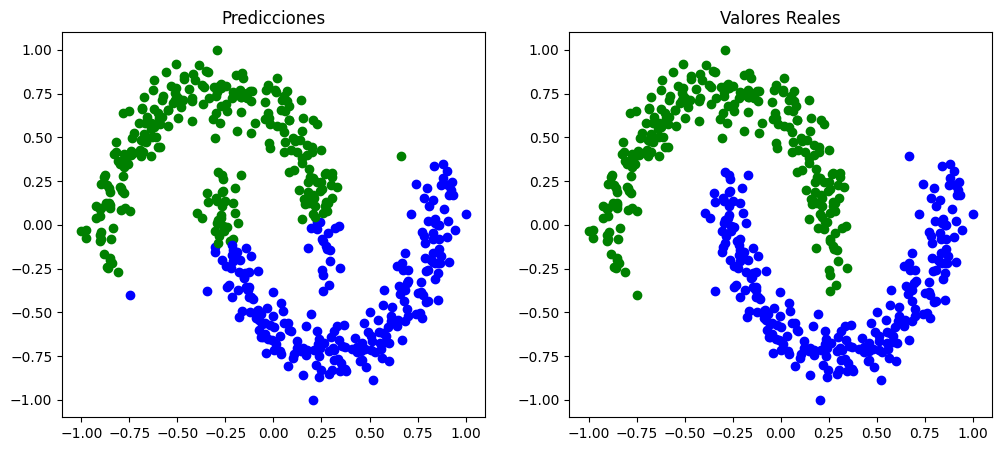

In [14]:
predictions = [Predictions(x, params_SGD,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [15]:
params_SGD_momentum = [-0.94029041,  1.76279408,  0.07174585, -0.08851703,  0.59543365,
       -0.61919009,  0.16678696, -0.11759714,  0.40629924, -0.21482006,
        0.15629836, -0.10974645,  0.16246831, -0.12307243,  0.23741627,
        0.00333674,  0.24791843, -0.00205158]

In [16]:
# Calcular coste con todos los datos y mirar precisión para criterio de parada.
cost_val = Cost_function(params_SGD_momentum, X_val, Y_val,nqubits)
cost_all = Cost_function(params_SGD_momentum, X_pad, Y,nqubits)

Loss:  0.43241086306503357 Acc:  0.85


Loss:  0.3534984650110077 Acc:  0.896


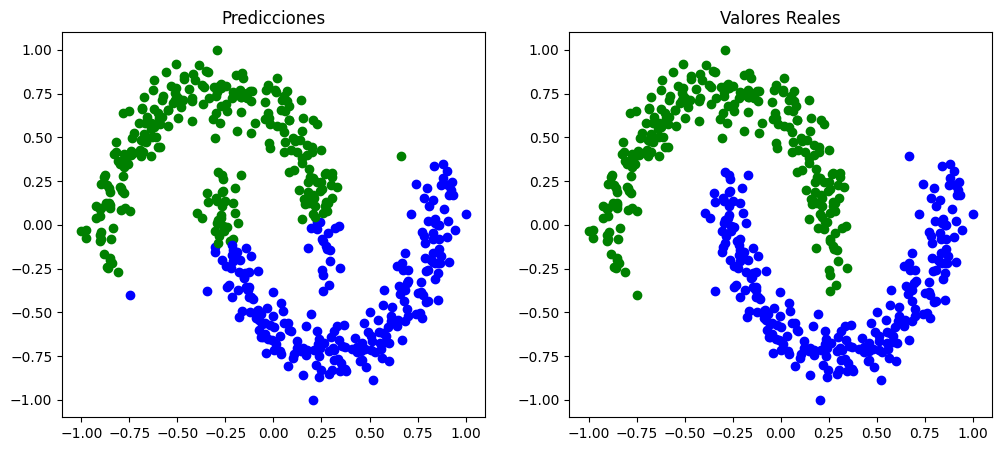

In [17]:
predictions = [Predictions(x, params_SGD_momentum,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [18]:
params_nesterov = [-1.16792912,  1.6060722 ,  0.0843576 , -0.02140028,  1.58956029,
        0.01566641,  1.48904306,  0.69655598,  0.82610582,  0.50128958,
        0.62812613, -0.04462584,  0.63429607, -0.05795183,  0.83151127,
        0.00333674,  0.84201342, -0.00205158]

In [19]:
# Calcular coste con todos los datos y mirar precisión para criterio de parada.
cost_val = Cost_function(params_nesterov, X_val, Y_val,nqubits)
cost_all = Cost_function(params_nesterov, X_pad, Y,nqubits)

Loss:  0.45130980034682855 Acc:  0.82


Loss:  0.3732143075303984 Acc:  0.874


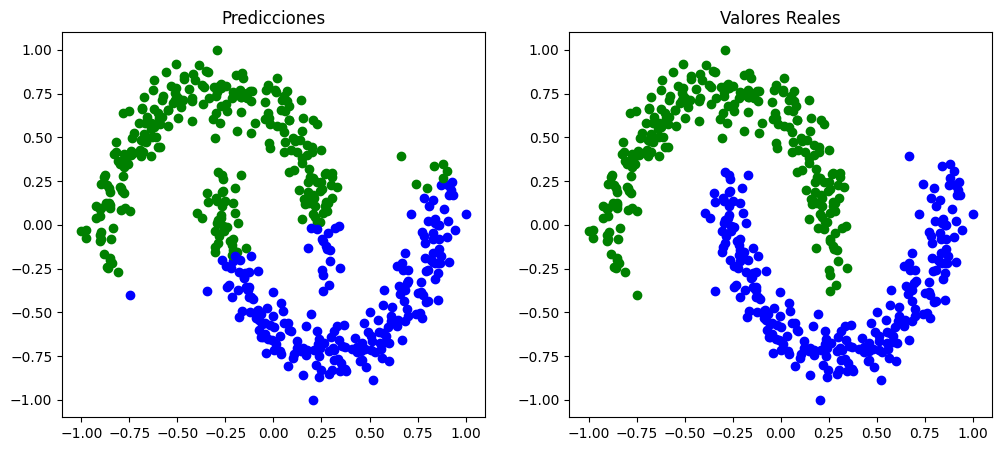

In [20]:
predictions = [Predictions(x, params_nesterov,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label       
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [21]:
params_adam = [-1.48232873e+00, -2.51308046e+00,  5.62069491e-01,  2.72334117e-01,
        1.86775543e-02,  4.87684609e-01,  5.09494809e-01,  4.27517459e-01,
       -1.02794316e-03,  4.33140725e-01,  5.01443413e-01,  4.41843375e-02,
        5.07613354e-01,  3.08583526e-02,  4.43715065e-03,  3.33674327e-03,
        1.49393091e-02, -2.05158266e-03]

In [22]:
# Calcular coste con todos los datos y mirar precisión para criterio de parada.
cost_val = Cost_function(params_adam, X_val, Y_val,nqubits)
cost_all = Cost_function(params_adam, X_pad, Y,nqubits)

Loss:  0.6442657540037081 Acc:  0.77


Loss:  0.6209059083737476 Acc:  0.796


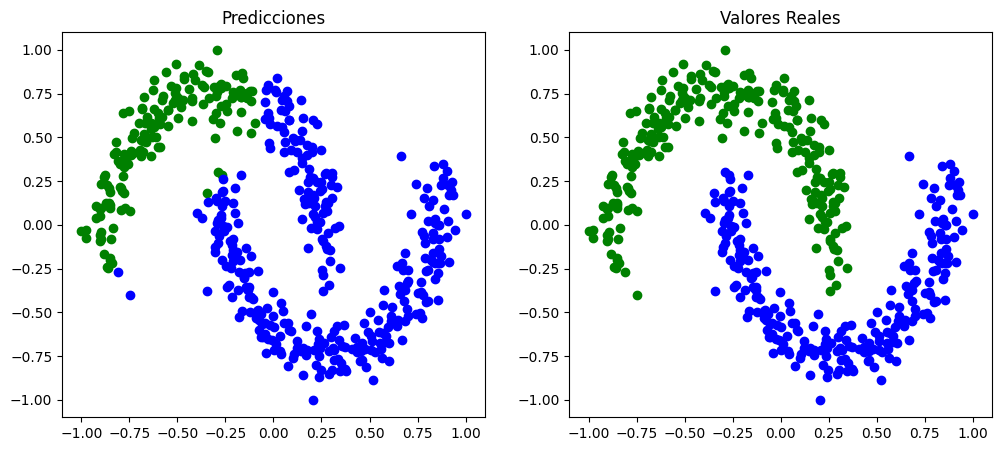

In [23]:
predictions = [Predictions(x, params_adam,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label       
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [24]:
params_adadelta = [-0.003568  ,  0.00432562,  0.01021908,  0.02240893,  0.0398887 ,
       -0.00748113,  0.03071376, -0.00137568,  0.02018069,  0.00424388,
        0.02265331,  0.01388976,  0.02882325,  0.00056377,  0.02565151,
        0.00333674,  0.03615367, -0.00205158]

In [25]:
# Calcular coste con todos los datos y mirar precisión para criterio de parada.
cost_val = Cost_function(params_adadelta, X_val, Y_val,nqubits)
cost_all = Cost_function(params_adadelta, X_pad, Y,nqubits)

Loss:  1.8635020982383261 Acc:  0.52


Loss:  1.9411585777667268 Acc:  0.5


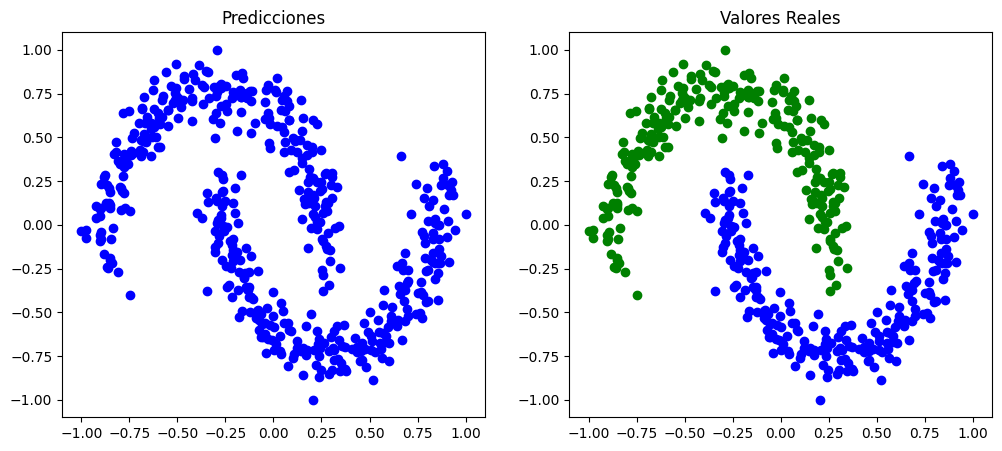

In [26]:
predictions = [Predictions(x, params_adadelta,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label       
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [27]:
params_powell = [5.78141512e+00,  2.94328489e+00,  8.82134090e-04,  4.07261522e-03,
  7.84590743e-01,  1.64362966e+00,  9.50088418e-03, -1.51357208e-03,
 -1.03218852e-03,  4.10598502e-03,  1.44043571e-03,  1.45427351e-02,
  7.61037725e-03,  1.21675016e-03,  4.43863233e-03,  3.33674327e-03,
  1.49407907e-02, -2.05158264e-03]

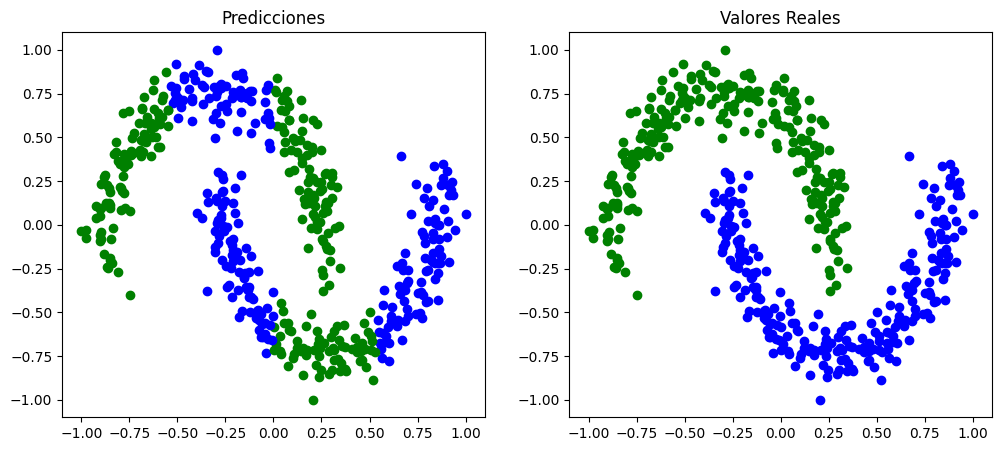

In [28]:
predictions = [Predictions(x, params_powell,nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label       
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")


In [29]:
# Cambiar valores de los parametros

params_BFGS = [-1.13857089e+00,  2.37978594e+00, -8.19608946e-05,  7.41954923e-05,
  5.95981338e-01, -7.80111697e-01,  2.72385273e-03, -3.69266125e-02,
  6.48136305e-01, -1.34811159e-02,  1.46589166e-01,  8.38802914e-02,
  1.52760468e-01,  7.05566292e-02,  1.92534534e-01,  3.33697291e-03,
  2.03037478e-01, -2.05223045e-03]

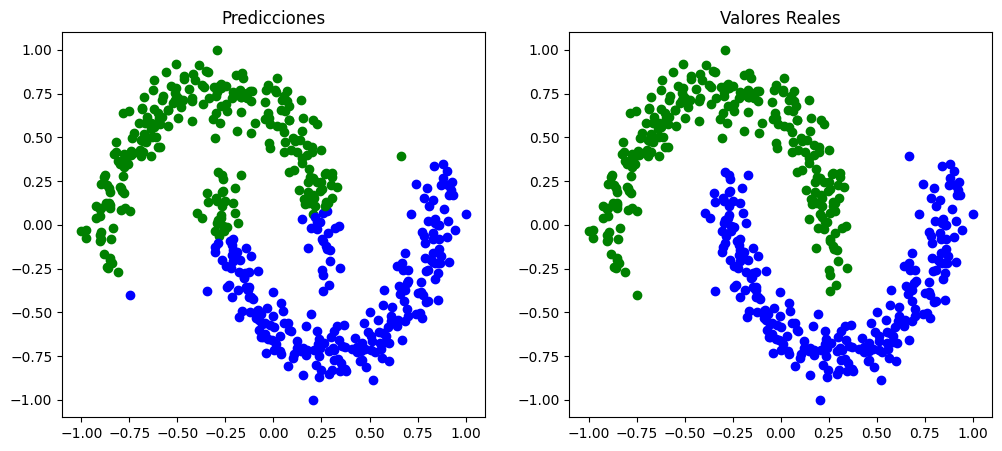

In [30]:
predictions = [Predictions(x, params_BFGS, nqubits) for x in X_pad]
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Visualizar las predicciones realizadas por el modelo
ax[0].set_title('Predicciones')
for x, y_target in zip(X_pad[:,0:2], predictions):
    if np.sign(y_target) == 1:
        ax[0].plot(x[0], x[1], "bo")
    else:
        ax[0].plot(x[0], x[1], "go")
        
# Visualizar los valores reales del label       
ax[1].set_title('Valores Reales')
for x, y_target in zip(X_pad[:,0:2], y):
    if y_target == 1:
        ax[1].plot(x[0], x[1], "bo")
    else:
        ax[1].plot(x[0], x[1], "go")
